# Position estimation experiments

This notebook serves to document various experiments performed on IMU data used to estimate position of a device. 

In [163]:
# Imports
import os
import datetime
import csv
import scipy as sp
from scipy import integrate
from scipy import signal
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


In [164]:
# Load data

isLoadMultipleDatasets = False

if isLoadMultipleDatasets:
    
    session_uuids = [
        "0abe1a03-7278-47f6-957d-0a4bfa3cecf4",
        "2f66b9bd-4c40-43e5-98a1-ee8fe70544ea",
        "26aa8e56-b218-48e2-b91a-e67d2b7e5305",
        "44adb431-c787-4dc0-9092-f8c5144bdca4",
        "58d6bd5c-3ec7-4c25-b7db-fc798282ad65",
        "848f2dd6-9c48-4317-b570-950c8994f828",
        "b3a2c750-b6aa-4c19-8188-4187461c5714",
        "c1be71c6-9eb2-4ca8-bf6f-648de79817f5",
        "e4a4f140-5cc1-4122-b71c-296b2b79f7af",
        "f44eda6b-931e-4e0c-8e67-f73dc684e42e",
    ]

    # IMU data
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    path_to_imu_data_processed = parent_path + "/datasets/" + "session-" + session_uuid + "/imu_data/processed/"

    timestamp = pd.read_csv(path_to_imu_data_processed + "timestamp.csv").values
    user_acceleration = pd.read_csv(path_to_imu_data_processed + "user_acceleration.csv")

else:
    session_uuid = "faf08194-faf2-4c0f-b58e-047ac252f30a"

    # IMU data
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    path_to_imu_data_processed = parent_path + "/datasets/" + "session-" + session_uuid + "/imu_data/processed/"

    timestamp = pd.read_csv(path_to_imu_data_processed + "timestamp.csv").values
    user_acceleration = pd.read_csv(path_to_imu_data_processed + "user_acceleration.csv")



In [165]:
def calculate_delta(timestamp_1, timestamp_2):
    """
    Calculate the time delta between image captures 

    return: time delta (in s)
    """
    
    difference = timestamp_1 - timestamp_2
    delta = (difference.seconds * 1) + (difference.microseconds / 1000000)
    
    return delta

In [166]:
# Time delta calculation
# Calculate the average time delta between sensor measurements
time = np.array([datetime.datetime.strptime(x[0], '%Y-%m-%d:%H:%M:%S.%f') for x in timestamp])

deltas = []
for i in range(len(time) - 1):
    deltas.append(calculate_delta(time[i+1], time[i]))

dt = np.array(deltas).mean()
print("Average sample period:\t", dt, "(s)")

Average sample period:	 0.029863306217315522 (s)


In [167]:
def convert_accelerometer(a, bias, addBias=False):
    
    if addBias:
        return (a-bias) * 9.8
    else:
        return a * 9.81

In [168]:
# Adjust of acceleration bias


# To get bias, first run "imu_gps_noise_analysis" notebook
# Read in bias values from _noise.csv

path_to_csv_file=path_to_imu_data_processed+"user_acceleration_noise.csv"
csv_file = open(path_to_csv_file)
csvreader = csv.reader(csv_file)
header = next(csvreader)
row = next(csvreader)
noise = list(map(lambda x: float(x), row))

addBias = False

# acceleration = []
# acceleration.append(np.array([a-bias_x for a in user_acceleration.x.values]))
# acceleration.append(np.array([a-bias_y for a in user_acceleration.y.values]))
# acceleration.append(np.array([a-bias_z for a in user_acceleration.z.values]))

# Convert accelerometer measurements from G's to m/s^2
acceleration = []
acceleration.append(np.array([convert_accelerometer(a, noise[0], addBias) for a in user_acceleration.x.values]))
acceleration.append(np.array([convert_accelerometer(a, noise[2], addBias) for a in user_acceleration.y.values]))
acceleration.append(np.array([convert_accelerometer(a, noise[4], addBias) for a in user_acceleration.z.values]))


Mean (x):	 -0.003814703685749836
Mean (y):	 -0.0032989813784636154
Mean (z):	 0.036433652870015674
Time:	 205.57900000000006


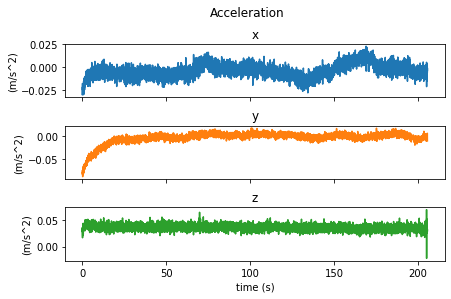

In [169]:
# Acceleration 

startTime = time[0]
ts = [calculate_delta(x, startTime) for x in time]

fig, axs = plt.subplots(3)
fig.tight_layout()
fig.suptitle("Acceleration")
fig.subplots_adjust(top=0.85)

axs[0].plot(ts, acceleration[0], color = "tab:blue")
axs[1].plot(ts, acceleration[1], color = "tab:orange")
axs[2].plot(ts, acceleration[2], color = "tab:green")

# axs[0].set_ylim(-0.1, 0.1)
# axs[1].set_ylim(-0.1, 0.1)
# axs[2].set_ylim(-0.1, 0.1)

axs[0].set_title('x')
axs[1].set_title('y')
axs[2].set_title('z')

axs[0].set_ylabel("(m/s^2)")
axs[1].set_ylabel("(m/s^2)")
axs[2].set_ylabel("(m/s^2)")
axs[2].set_xlabel("time (s)")

for ax in fig.get_axes():
    ax.label_outer()

print("Mean (x):\t", acceleration[0].mean())
print("Mean (y):\t", acceleration[1].mean())
print("Mean (z):\t", acceleration[2].mean())

print("Time:\t", dt*(len(acceleration[0])-1))

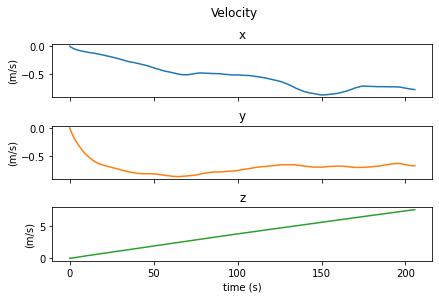

In [170]:
# Velocity

velocity = []
velocity.append(integrate.cumulative_trapezoid(y=acceleration[0], dx=dt))
velocity.append(integrate.cumulative_trapezoid(y=acceleration[1], dx=dt))
velocity.append(integrate.cumulative_trapezoid(y=acceleration[2], dx=dt))

# Detrend result of integration to eliminate drift errors
for v in velocity:
    v = signal.detrend(v)

fig, axs = plt.subplots(3)
fig.tight_layout()
fig.suptitle("Velocity")
fig.subplots_adjust(top=0.85)

axs[0].plot(ts[:-1], velocity[0], color = "tab:blue")
axs[1].plot(ts[:-1], velocity[1], color = "tab:orange")
axs[2].plot(ts[:-1], velocity[2], color = "tab:green")

# axs[0].set_ylim(-0.05, 0.05)
# axs[1].set_ylim(-0.05, 0.05)
# axs[2].set_ylim(-0.05, 0.05)

axs[0].set_title('x')
axs[1].set_title('y')
axs[2].set_title('z')

axs[2].set_xlabel("time (s)")
axs[0].set_ylabel("(m/s)")
axs[1].set_ylabel("(m/s)")
axs[2].set_ylabel("(m/s)")

for ax in fig.get_axes():
    ax.label_outer()


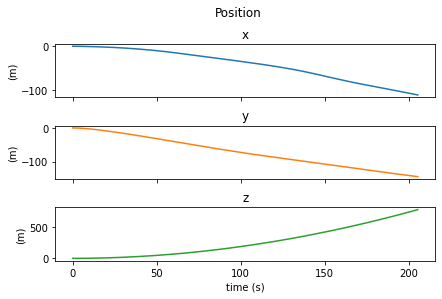

In [171]:
# Position

position = []
position.append(integrate.cumulative_trapezoid(y=velocity[0], dx=dt))
position.append(integrate.cumulative_trapezoid(y=velocity[1], dx=dt))
position.append(integrate.cumulative_trapezoid(y=velocity[2], dx=dt))

# Detrend result of integration to eliminate drift errors
for p in position:
    p = signal.detrend(p)

fig, axs = plt.subplots(3)
fig.tight_layout()
fig.suptitle("Position")
fig.subplots_adjust(top=0.85)

axs[0].plot(ts[:-2], position[0], color = "tab:blue")
axs[1].plot(ts[:-2], position[1], color = "tab:orange")
axs[2].plot(ts[:-2], position[2], color = "tab:green")

# axs[0].set_ylim(-0.05, 0.05)
# axs[1].set_ylim(-0.05, 0.05)
# axs[2].set_ylim(-0.05, 0.05)

axs[0].set_title('x')
axs[1].set_title('y')
axs[2].set_title('z')

axs[2].set_xlabel("time (s)")
axs[1].set_ylabel("(m)")
axs[0].set_ylabel("(m)")
axs[2].set_ylabel("(m)")

for ax in fig.get_axes():
    ax.label_outer()


P_0:	 -3.402374536179171e-05 -0.0001101494336493516 4.074737938313979e-05
P_1:	 -110.9794338254018 -144.51234896533478 785.8882989407375


/var/folders/00/gk5sbk2j43n15xwxrqjn9fdc0000gn/T/ipykernel_3654/2936185758.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


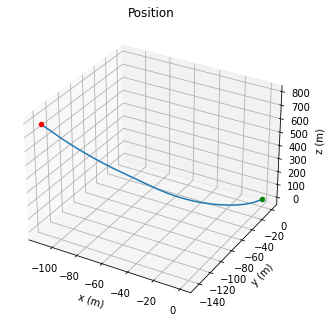

In [172]:
# Position — 3D view

fig = plt.figure()
ax = Axes3D(fig)
plt.title('Position')
ax.plot3D(position[0], position[1], position[2])

# Start and end points
ax.scatter(position[0][0], position[1][0], position[2][0], color='green', marker='o')
ax.scatter(position[0][-1], position[1][-1], position[2][-1], color='red', marker='o')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

print("P_0:\t", position[0][0], position[1][0], position[2][0])
print("P_1:\t", position[0][-1], position[1][-1], position[2][-1])

# ax.view_init(0)
